In [2]:
#I sometimes uses these libraries for interactive plots / exploration - they're not necessary for the standard notebook
#import ipywidgets as widgets
#from ipywidgets import interact, interact_manual
#import mplleaflet
#from geopandas import GeoDataFrame
#import multiprocessing

In [3]:
from route_shape_process_scripts import get_most_used_shape_id_per_direction, calc_distance
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
import boto3
import io
import time
import numpy as np
import math

# point this to your local copy of combined GTFS files --- see notebook `gtfs-realtime/route_shape_process/01_gtfs_transform.ipynb` 

In [4]:
full_routes_gtfs = pd.read_csv("/Users/benjaminmalnor/sandbox/bus350/gtfs-realtime/route_shape_process/input_gtfs/gtfs_routes_2018-08-15_2018-12-12.csv",low_memory=False)
full_trip_stop_schedule = pd.read_csv("/Users/benjaminmalnor/sandbox/bus350/gtfs-realtime/route_shape_process/input_gtfs/gtfs_2018-08-15_2018-12-12.csv",low_memory=False)

In [5]:
#create a quick dictionary to convert route short name (easier to remember) with route_id
route_name_to_id_dict = dict(zip(full_routes_gtfs.route_short_name.tolist(),
                                full_routes_gtfs.route_id.tolist()))

In [4]:
#Highest ridership - 41, D, 7, 40,C,
#Top 25% of urban routes - 5, 15X, 41, 70, C, D, E

# put multiple routes into one .csv to test if this could work as a table view in Tableau/Power BI

In [ ]:
def get_time_diff(df):
    '''
    '''
    df.sort_values('time_pct',ascending=True, inplace=True)
    df.loc[:,'new_time_delta'] = df['time_pct'].diff(1)
    return df

In [11]:
route_of_interest_list = ['41','7', '40','C Line','5', '15','70', 'E Line']
#'D Line'
full_positions_clean = pd.DataFrame()
directions = [0,1]
for route_loop_idx, route in enumerate(route_of_interest_list):
    route_of_interest = route
    for direction_loop_idx, direction in enumerate(directions):
        direction_of_interest = direction
        route_id = route_name_to_id_dict[route_of_interest]
        shape_id, trip_headsign = get_most_used_shape_id_per_direction(full_trip_stop_schedule, 
                                                                       route_id, 
                                                                       direction_of_interest)
        #get file from S3
        base_key = "route_shape_files/"
        csv_name = 'transformed/route_{}_{}_shape_{}_node_trips_w_nearest_2018-08-15_2018-12-11.csv'.format(
                                                        route_of_interest,
                                                        "".join(trip_headsign.replace("/","-").split(" ")) ,
                                                        shape_id)

        file_key = base_key+csv_name
        s3 = boto3.client("s3")
        bucket_name = "malnor.seattle.bustime"
        s3_object = s3.get_object(Bucket=bucket_name, Key=file_key)
        unpacked_positions_full = pd.read_csv(io.BytesIO(s3_object['Body'].read()))
        unpacked_positions_full['distance_btw_veh_and_shape'] = unpacked_positions_full\
                                                                .apply(lambda x: calc_distance(x['vehicle_lat'],
                                                                x['vehicle_long'], 
                                                                x['shape_pt_lat'],
                                                               x['shape_pt_lon']), axis=1)
        
        unpacked_positions_full_preclean = unpacked_positions_full\
            [(unpacked_positions_full['distance_btw_veh_and_shape']<=100)&
            (unpacked_positions_full['shape_dist_diff']>=0)]
        
        #convert time_pct to datetime
        unpacked_positions_full_preclean['time_pct'] = unpacked_positions_full_preclean['time_pct']\
                                                    .apply(pd.to_datetime).copy()
            
        unpacked_positions_full_preclean_newtime = unpacked_positions_full_preclean\
                        .groupby('month_day_trip_veh')\
                        .apply(get_time_diff)
                
        unpacked_positions_full_preclean_newtime['new_total_seconds'] = unpacked_positions_full_preclean_newtime.apply(lambda x: x['new_time_delta'].total_seconds() 
                                                         if x['new_time_delta'] == x['new_time_delta'] 
                                                         else 0, axis=1)
        
        unpacked_positions_full_preclean_newtime['new_veh_mph'] = unpacked_positions_full_preclean_newtime\
                        .apply(lambda x: (x['shape_dist_diff']/5280)
                               /(x['new_total_seconds']/(60*60)) if x['new_total_seconds'] != 0 else 0, axis=1)
            
        
        
        unpacked_positions_clean = unpacked_positions_full_preclean_newtime\
            [(unpacked_positions_full_preclean_newtime['new_veh_mph']>=0)&
            (unpacked_positions_full_preclean_newtime['new_veh_mph']<80)].copy()
        
        #Metro “Peak” hours: 6 – 9 a.m. and 3 – 7 p.m
        hours_of_interest = [6,7,8,9,15, 16, 17, 18, 19]
        #dow - Monday = 0
        dow_of_interest = [0,1,2,3,4]
        unpacked_positions_clean_hours = unpacked_positions_clean\
                                                [(unpacked_positions_clean['hour'].isin(hours_of_interest))&
                                                (unpacked_positions_clean['dow'].isin(dow_of_interest))]
            
        total_num_trips = len(unpacked_positions_clean_hours['month_day_trip_veh'].unique())
        ten_percent_trips = 10 #total_num_trips*.1
        shape_pt_obs_count = unpacked_positions_clean_hours.pivot_table(values='new_veh_mph', 
                                              index='month_day_trip_veh', 
                                              columns='shape_pt_sequence',
                                                aggfunc='count')\
                                                .sum(axis=0)
        shape_pt_obs_df = pd.DataFrame.from_dict(dict(zip(shape_pt_obs_count.index,
                                                          shape_pt_obs_count.values<ten_percent_trips)), orient='index')

        shape_pt_to_keep = shape_pt_obs_df[shape_pt_obs_df[0]==False].index.tolist()
            
        positions_final_clean = unpacked_positions_clean_hours[unpacked_positions_clean_hours['shape_pt_sequence'].isin(shape_pt_to_keep)]
        
        if full_positions_clean.empty:
            print("full_positions_clean is empty, route_idx = {}, direction_idx = {}".format(route_loop_idx, 
                                                                                             direction_loop_idx))
            full_positions_clean = positions_final_clean.copy()
        else:
            print("adding data for route_idx = {}, direction_idx = {}".format(route_loop_idx, 
                                                                             direction_loop_idx))
            full_positions_clean = full_positions_clean.append(positions_final_clean)

/Users/benjaminmalnor/anaconda2/envs/geopy36/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


full_positions_clean is empty, route_idx = 0, direction_idx = 0
adding data for route_idx = 0, direction_idx = 1
adding data for route_idx = 1, direction_idx = 0
adding data for route_idx = 1, direction_idx = 1
adding data for route_idx = 2, direction_idx = 0
adding data for route_idx = 2, direction_idx = 1
adding data for route_idx = 3, direction_idx = 0
adding data for route_idx = 3, direction_idx = 1
adding data for route_idx = 4, direction_idx = 0
adding data for route_idx = 4, direction_idx = 1
adding data for route_idx = 5, direction_idx = 0
adding data for route_idx = 5, direction_idx = 1
adding data for route_idx = 6, direction_idx = 0
adding data for route_idx = 6, direction_idx = 1
adding data for route_idx = 7, direction_idx = 0
adding data for route_idx = 7, direction_idx = 1


In [12]:
full_positions_clean.to_csv("multiple_routes_trips_w_nearest_2018-08-15_2018-12-11.csv", index=False)

# save figures - to do - look into dropping figures from memory after saved

/Users/benjaminmalnor/anaconda2/envs/geopy36/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


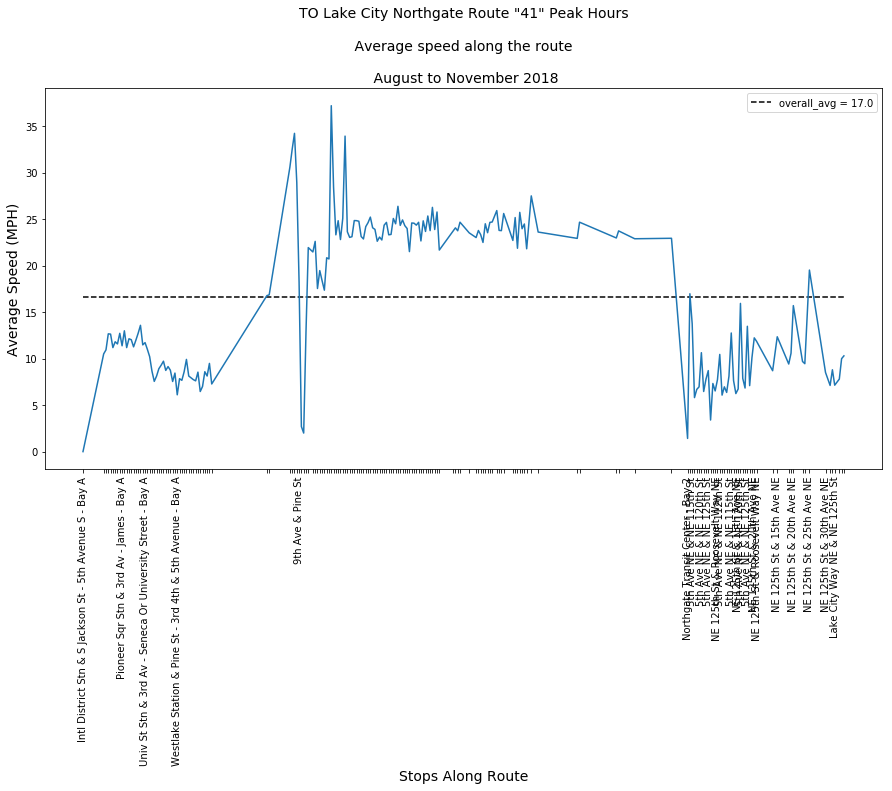

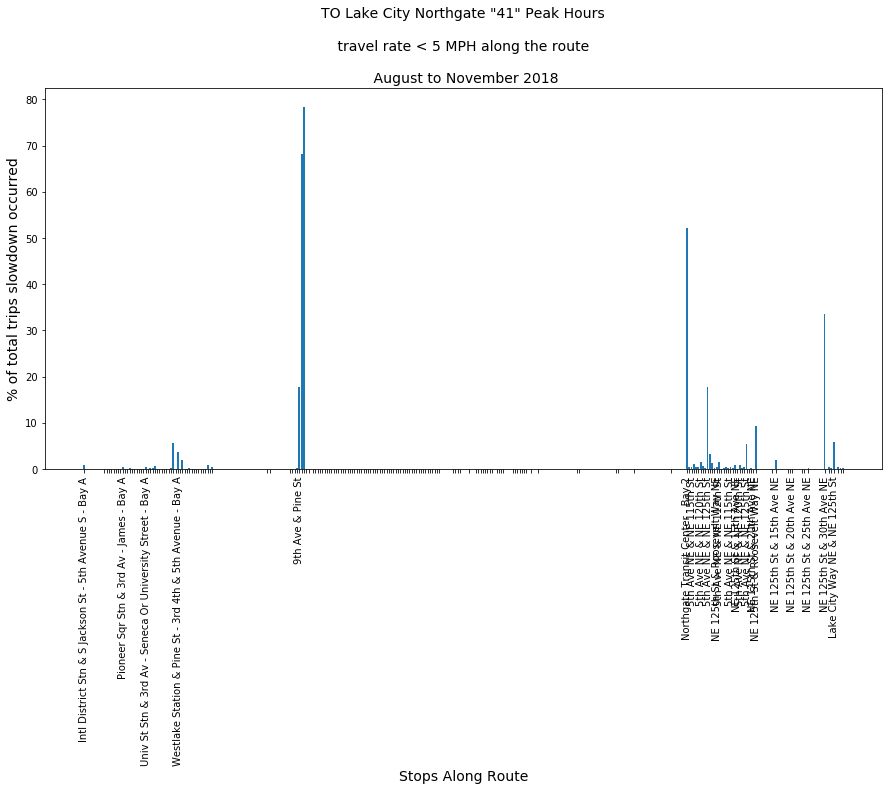

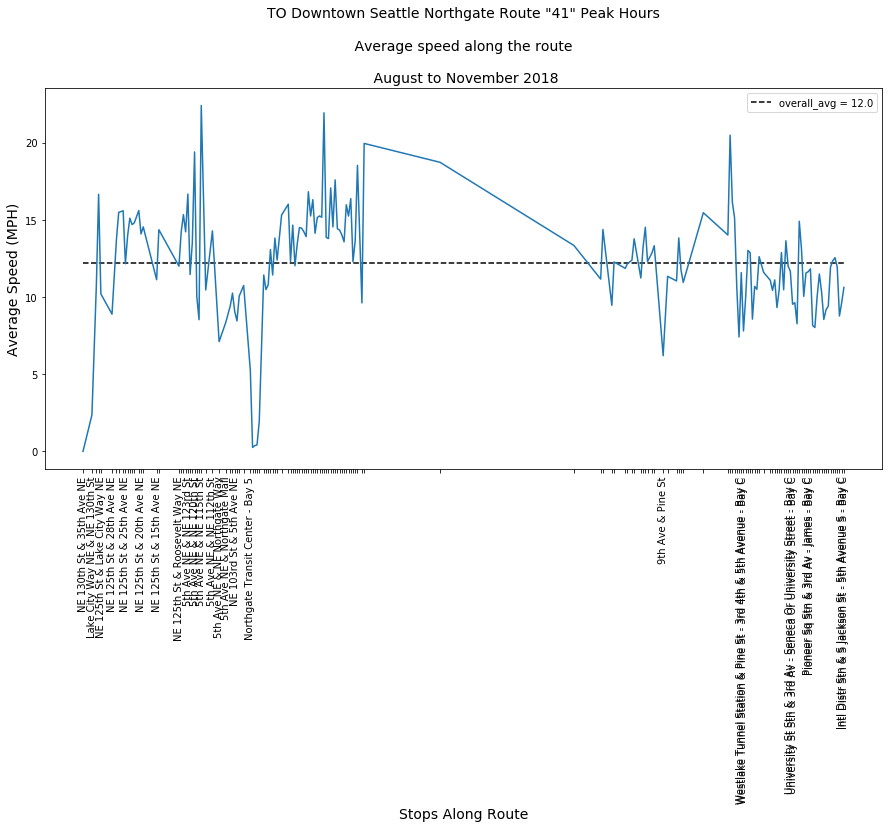

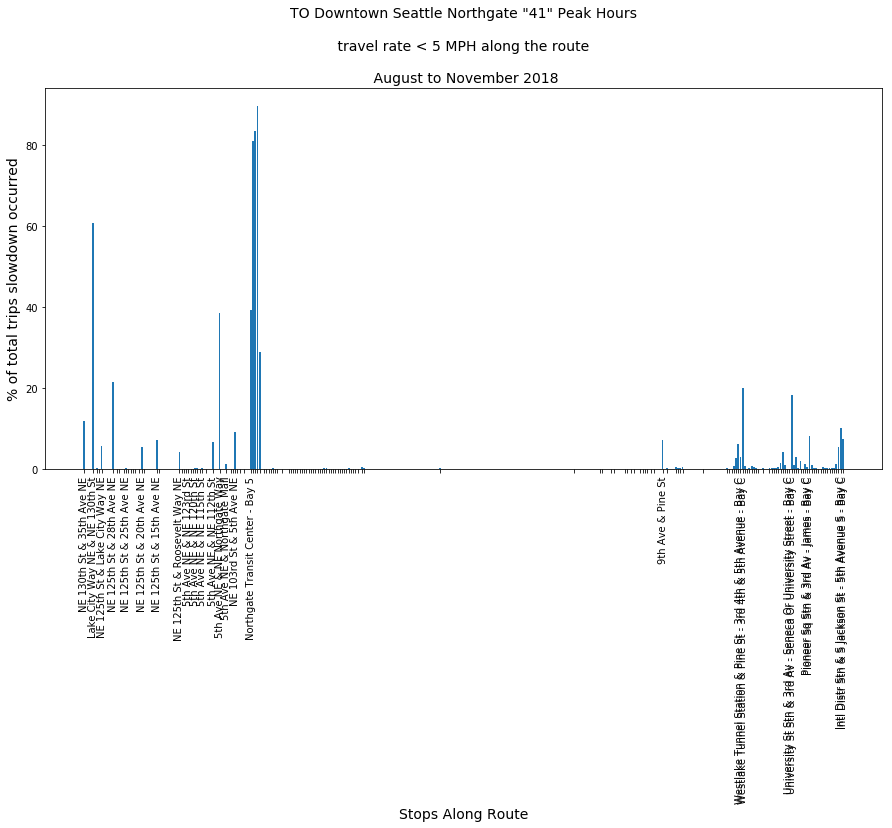

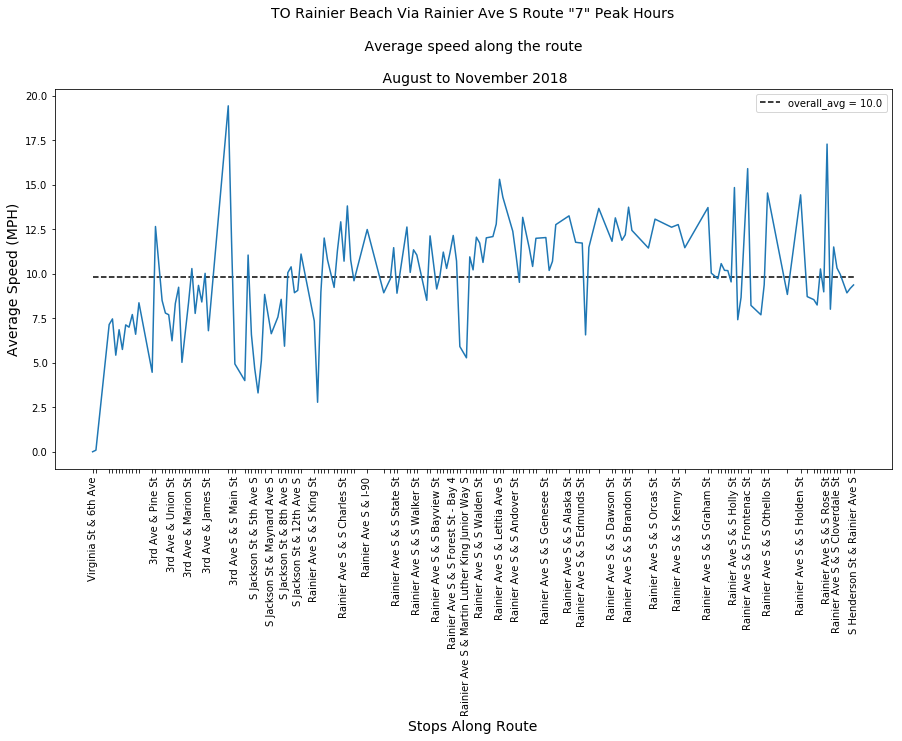

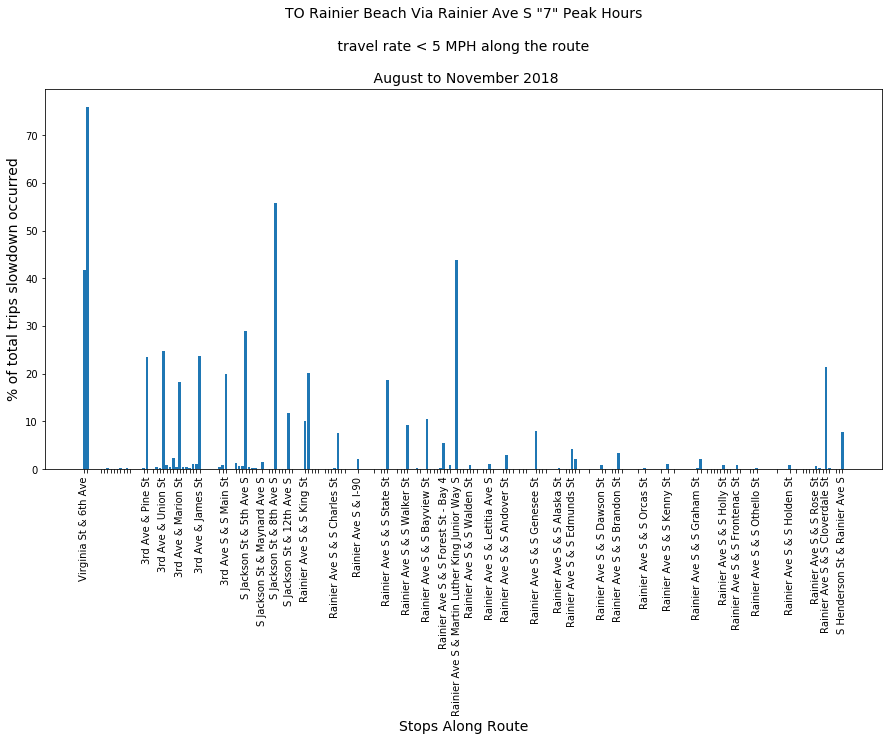

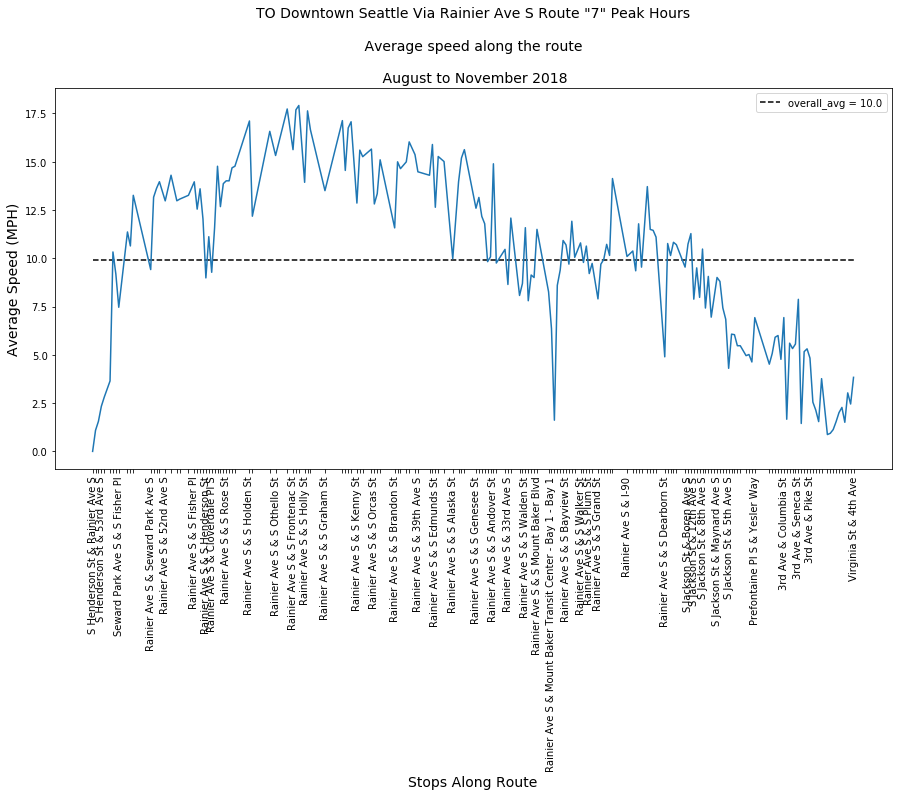

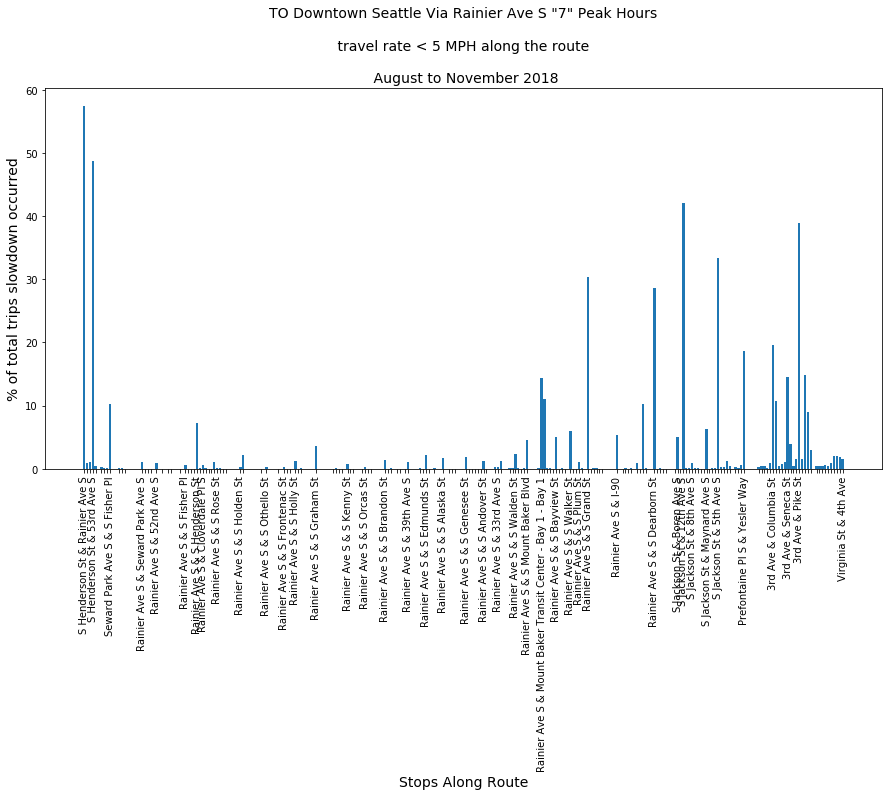

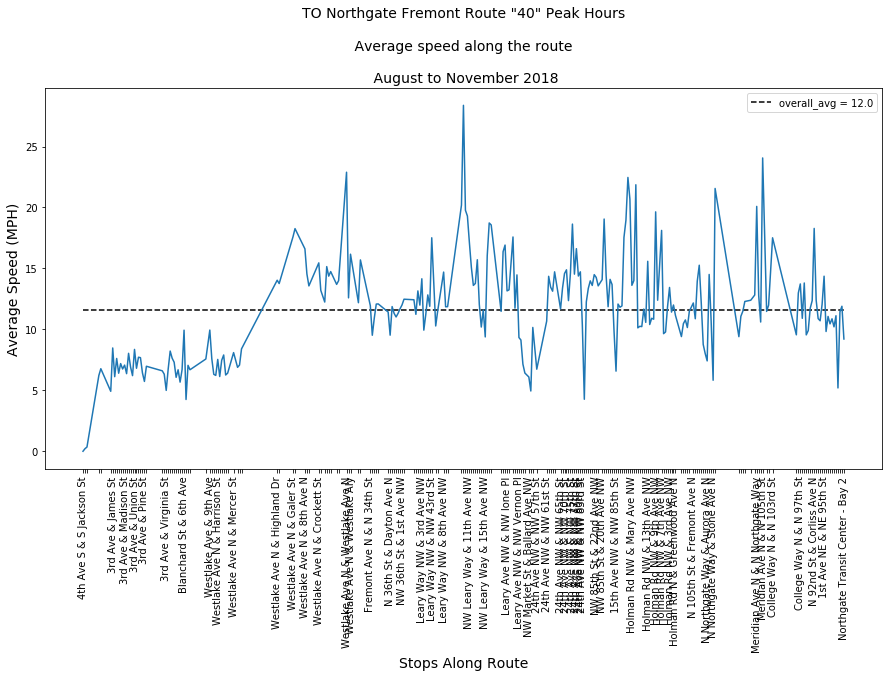

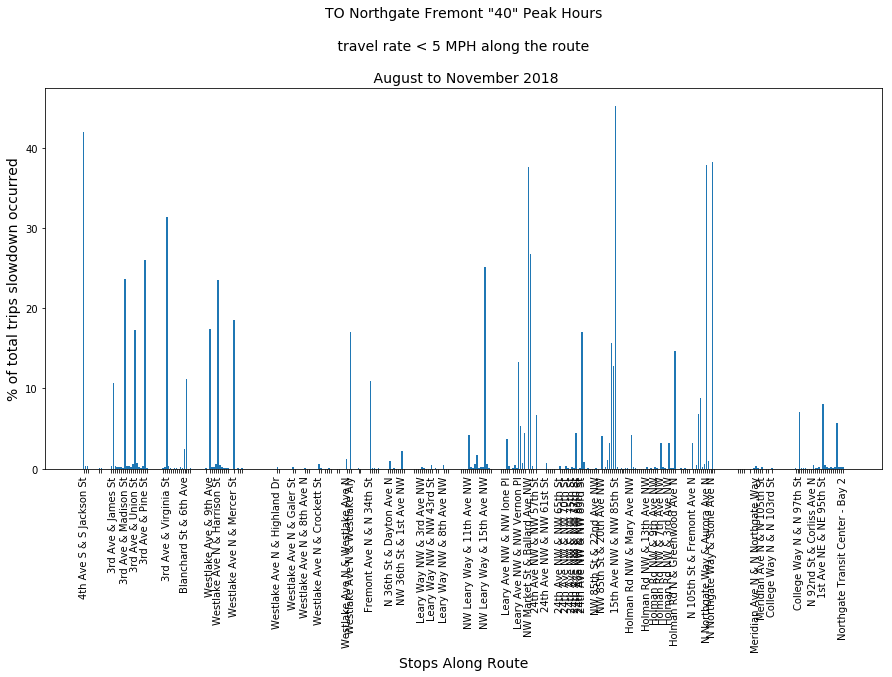

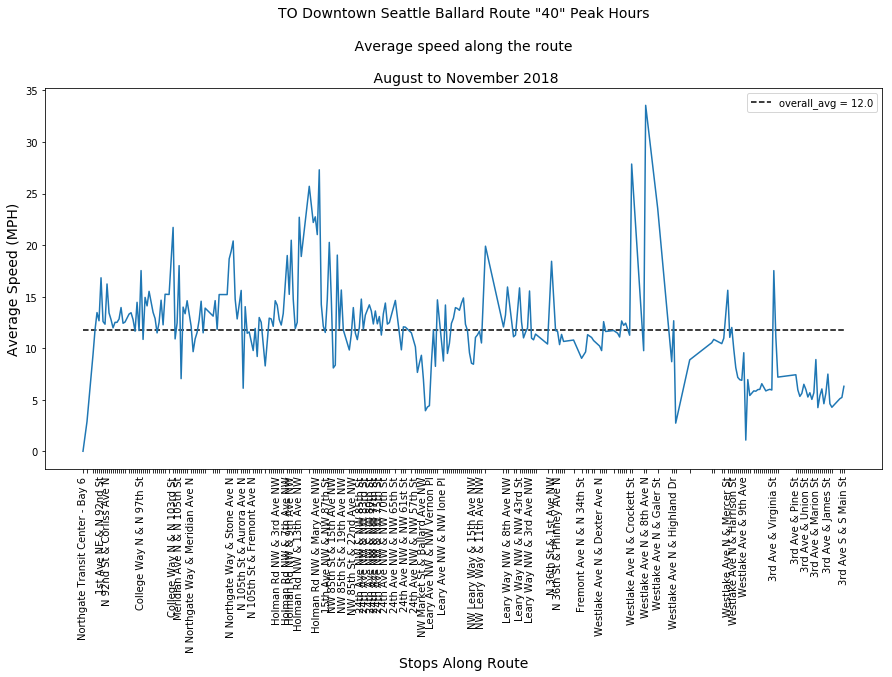

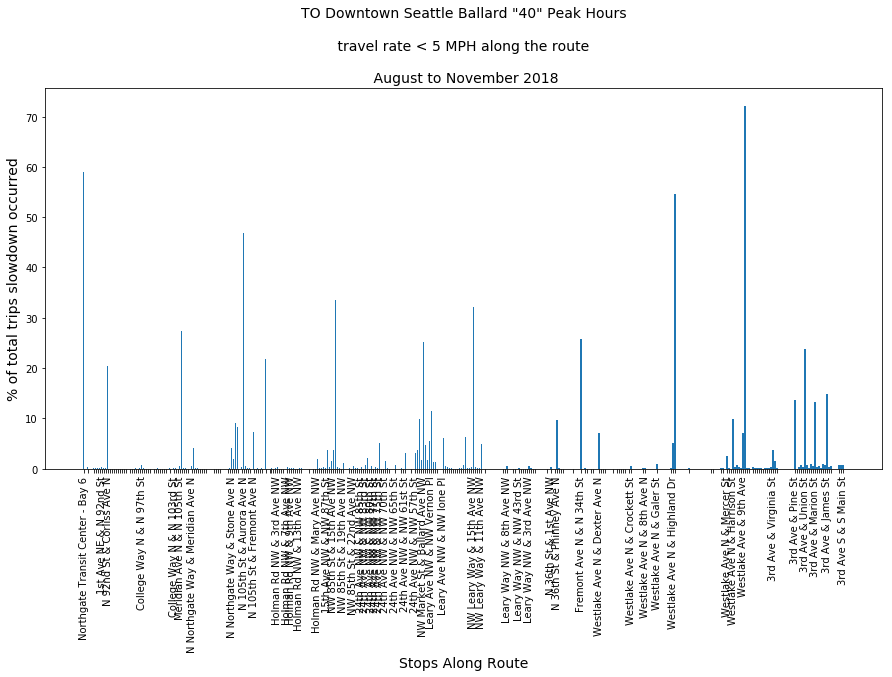

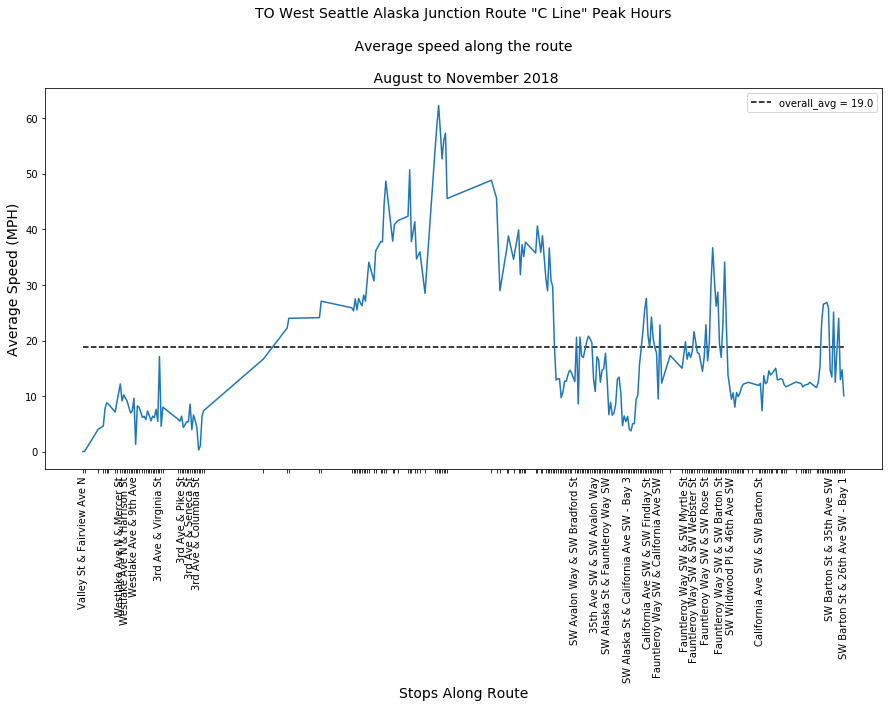

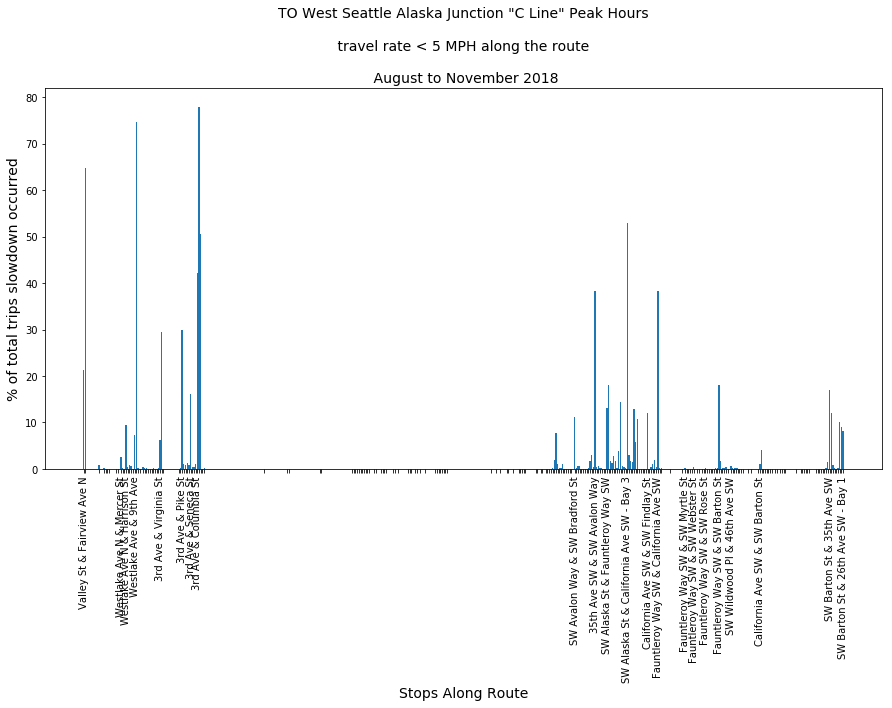

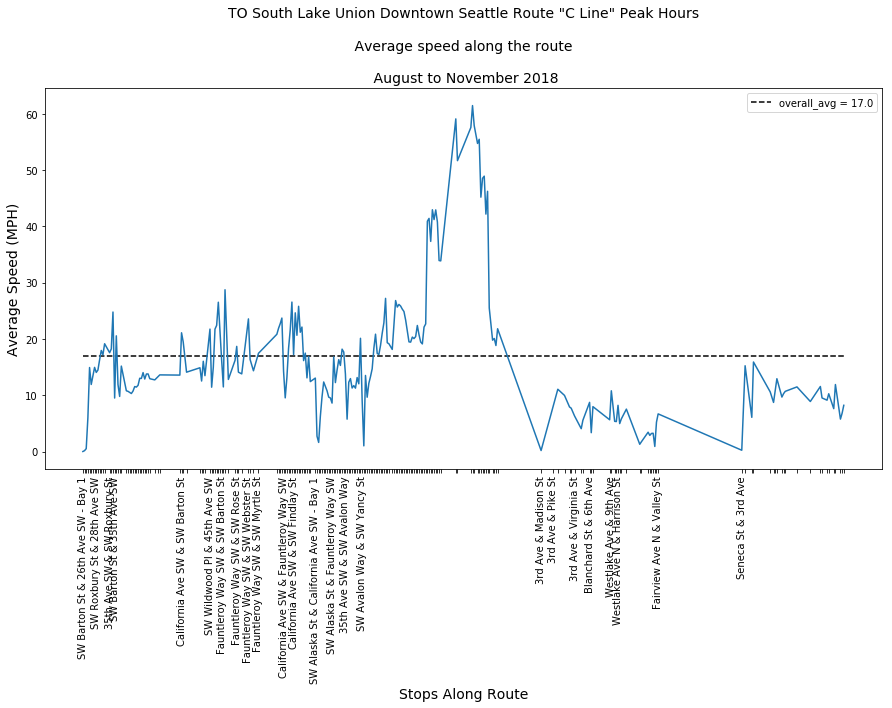

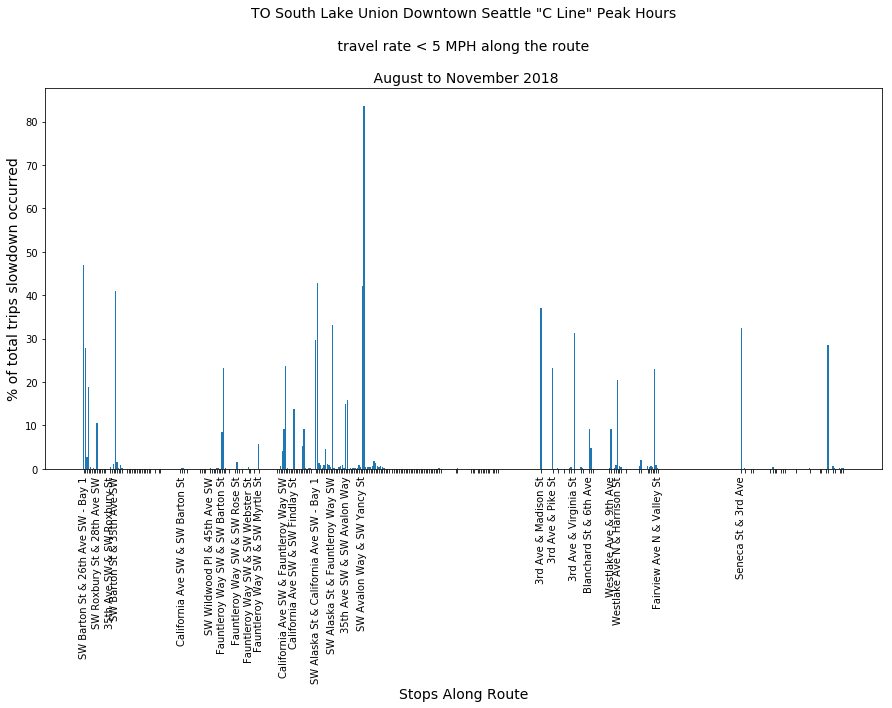

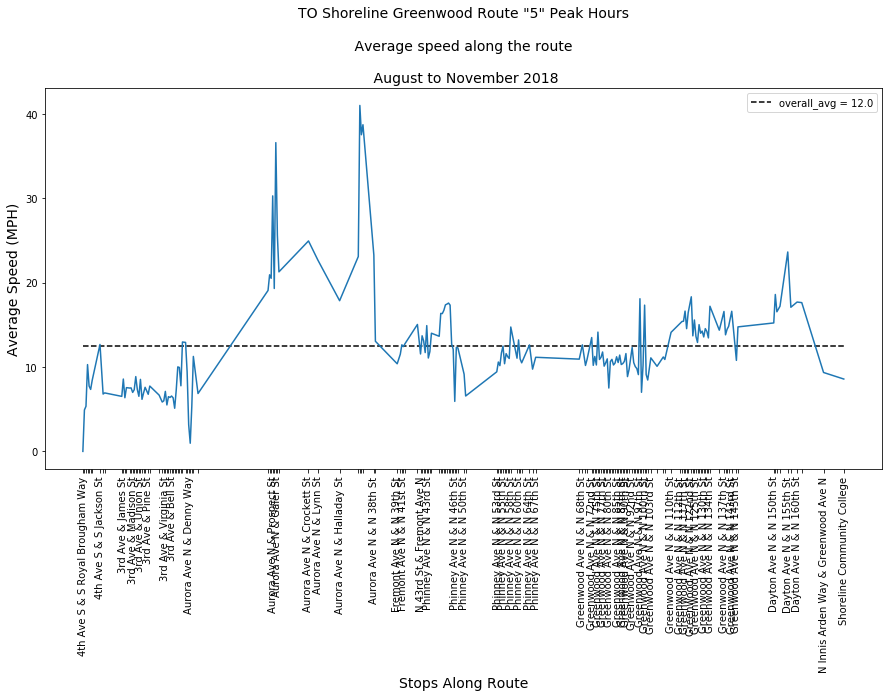

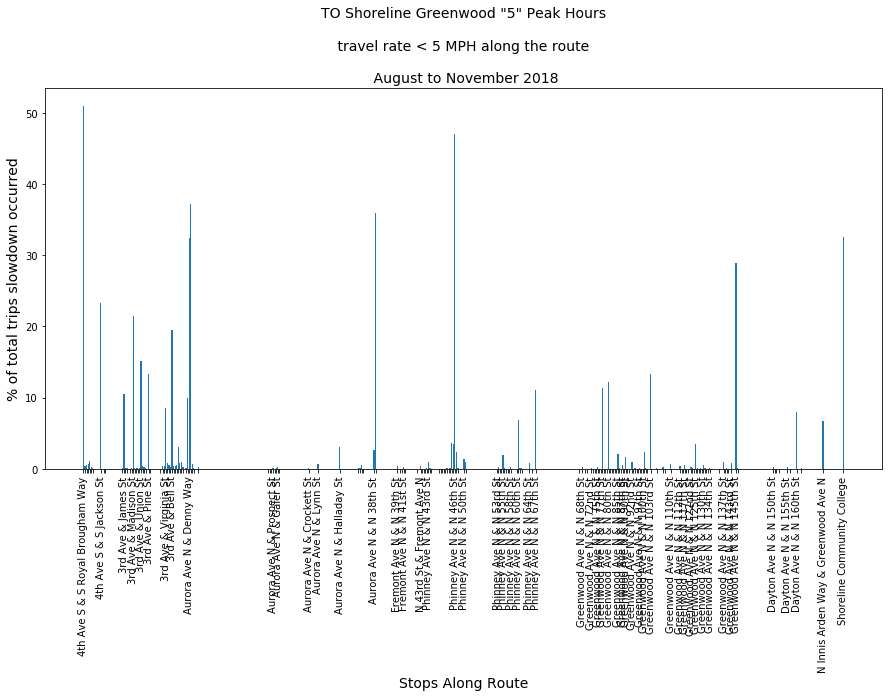

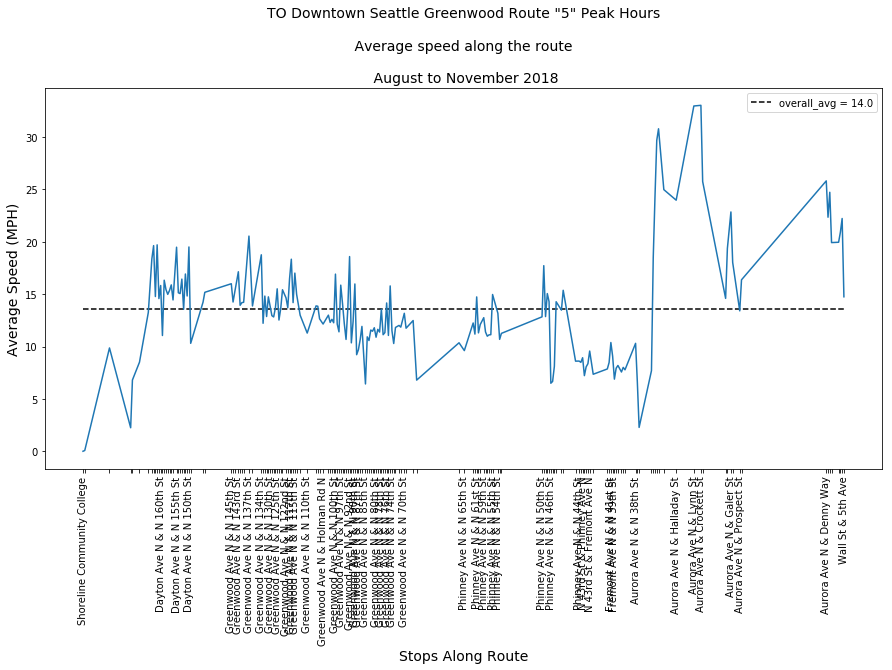

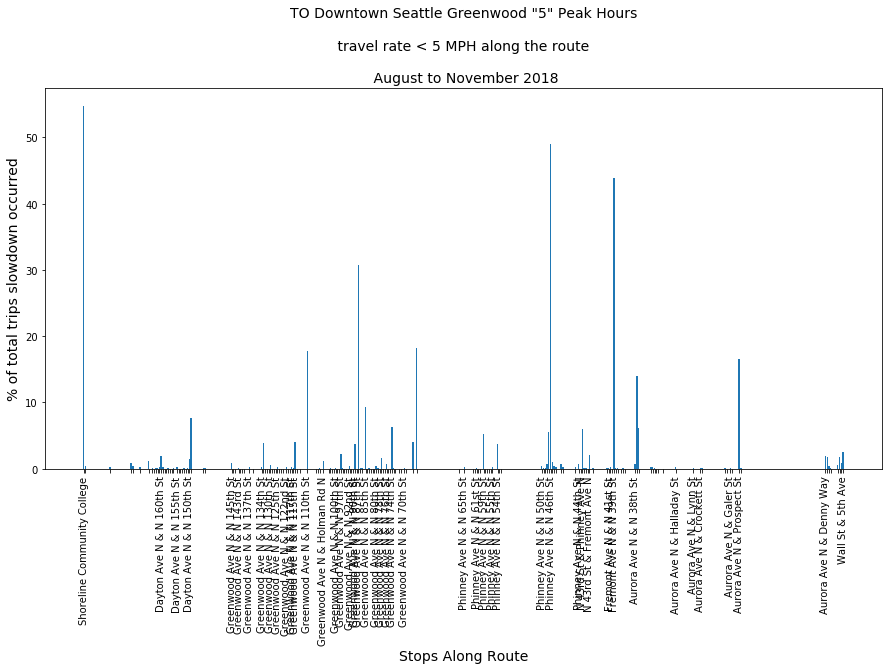

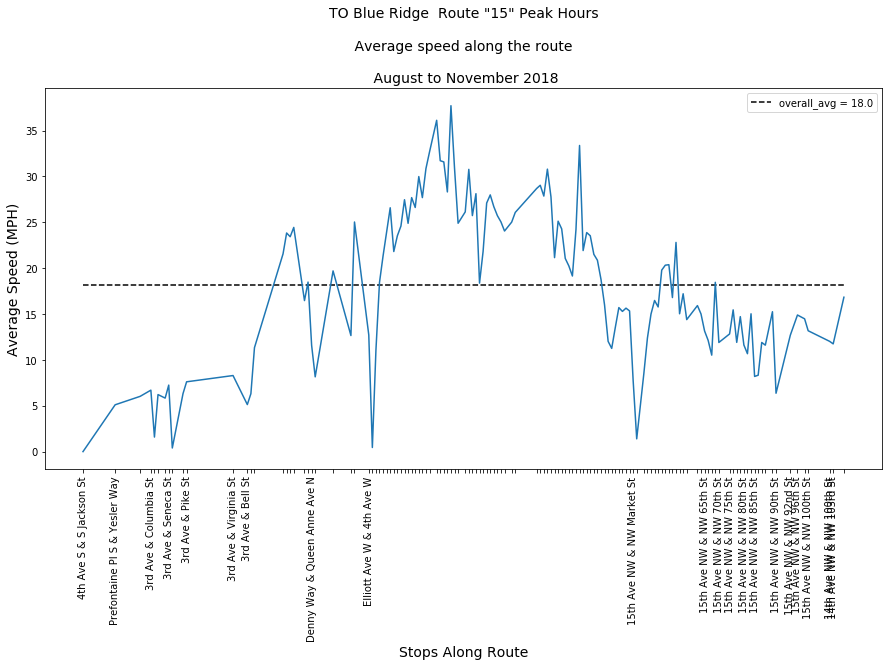

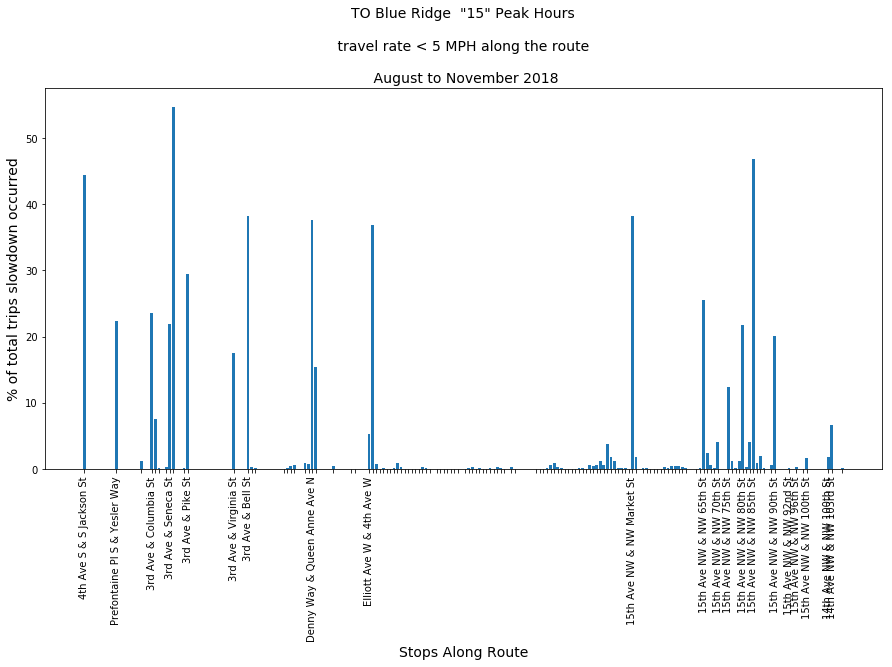

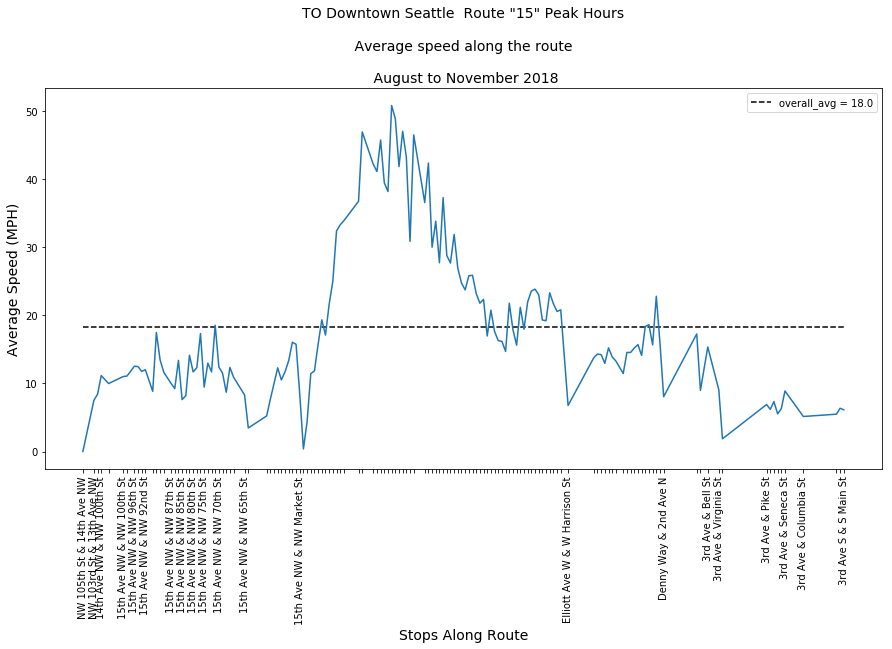

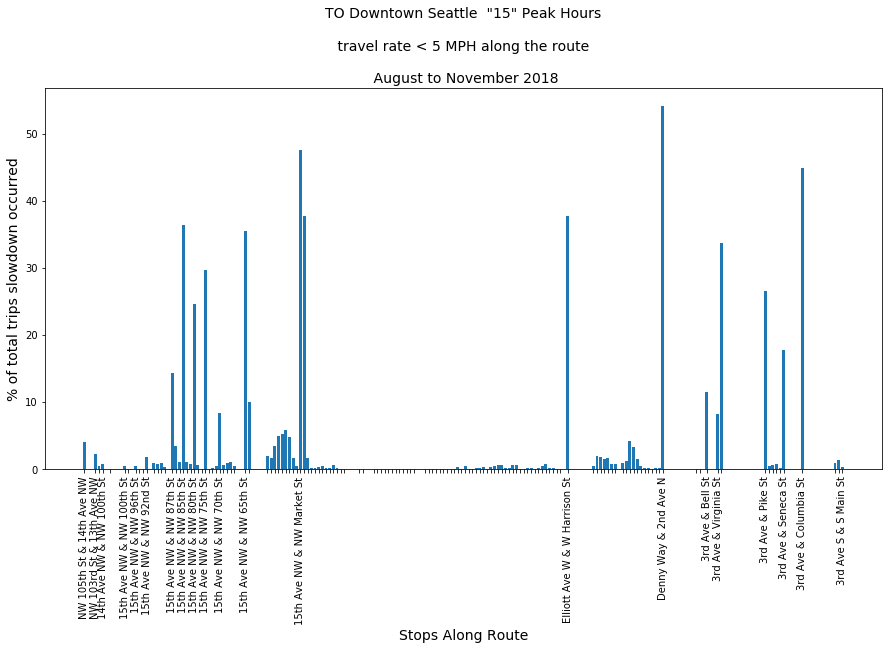

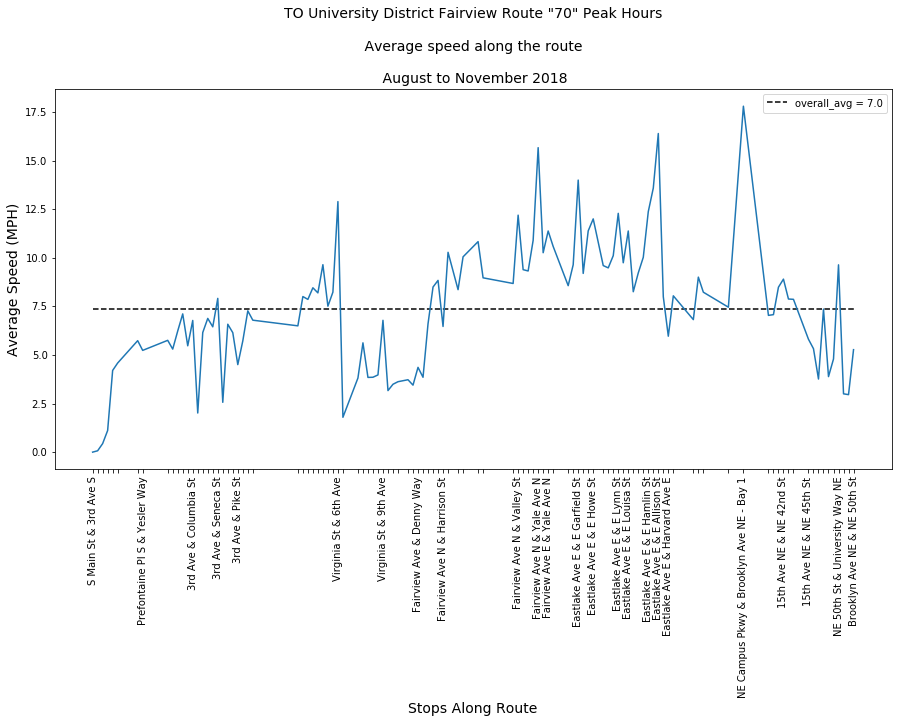

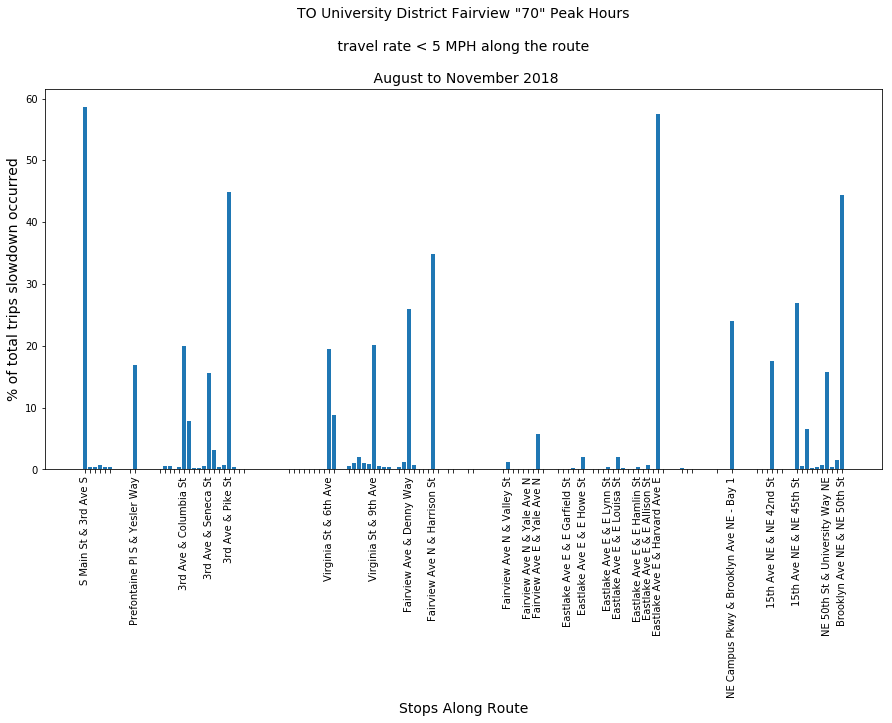

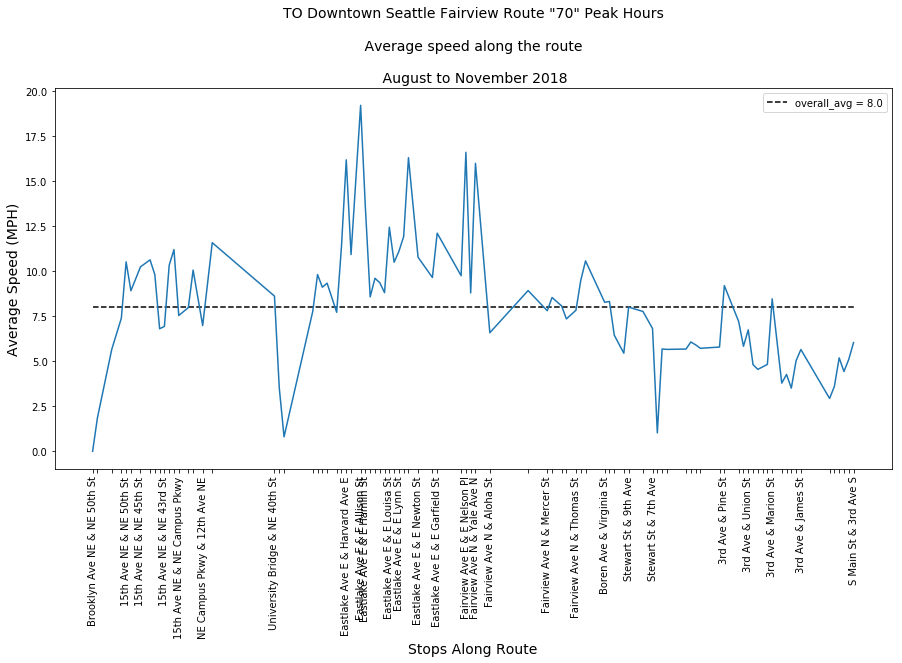

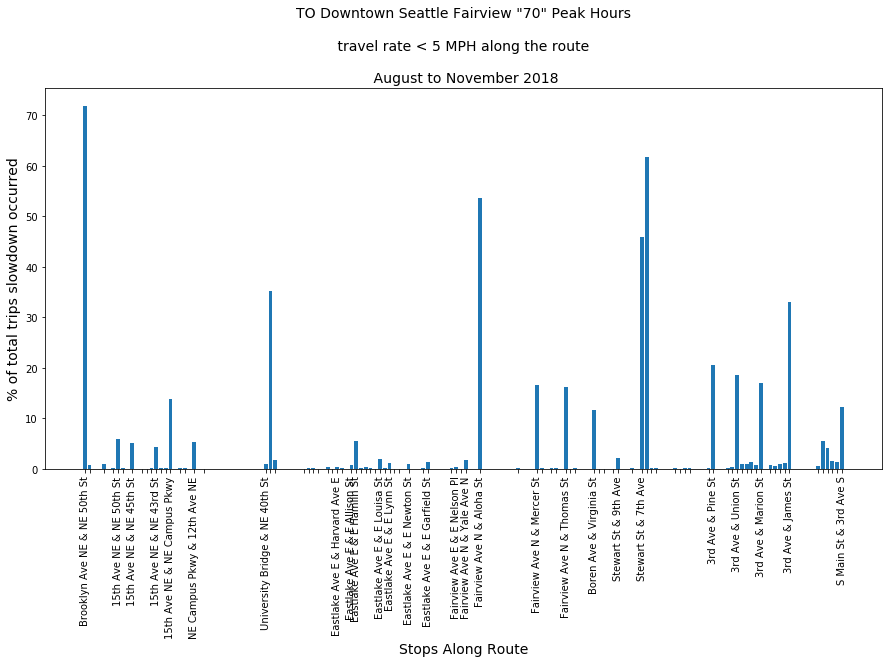

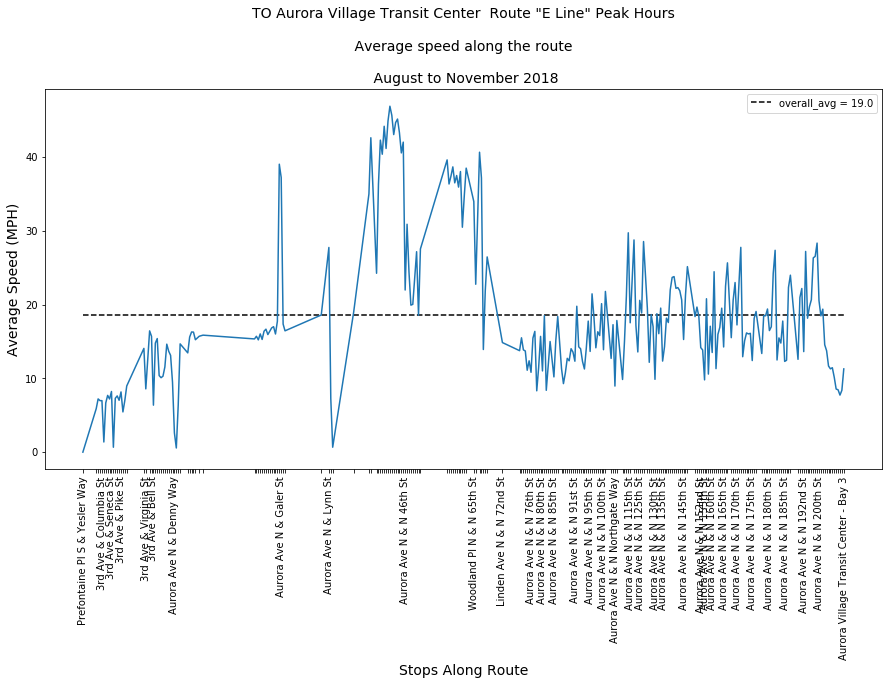

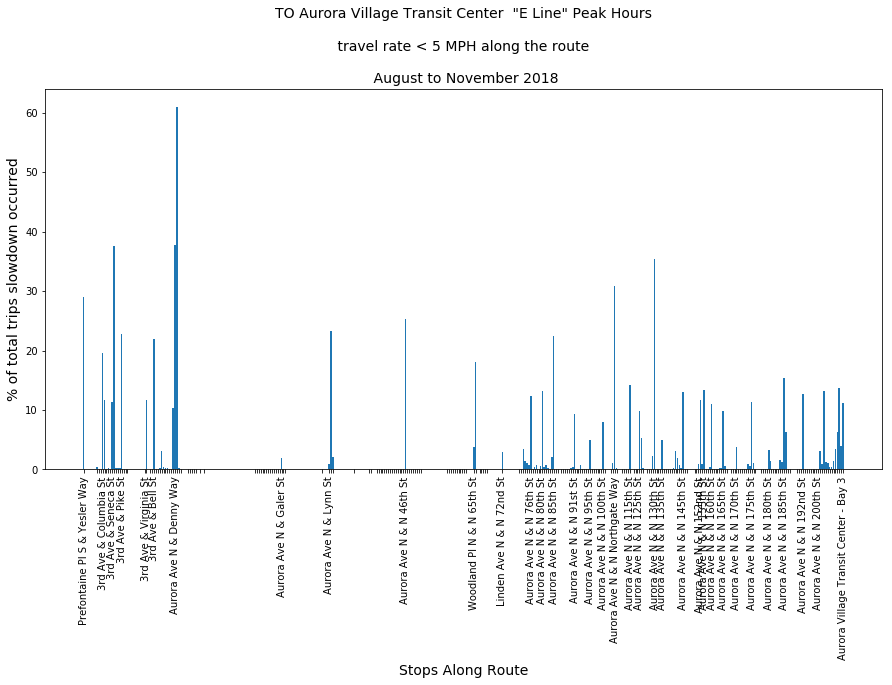

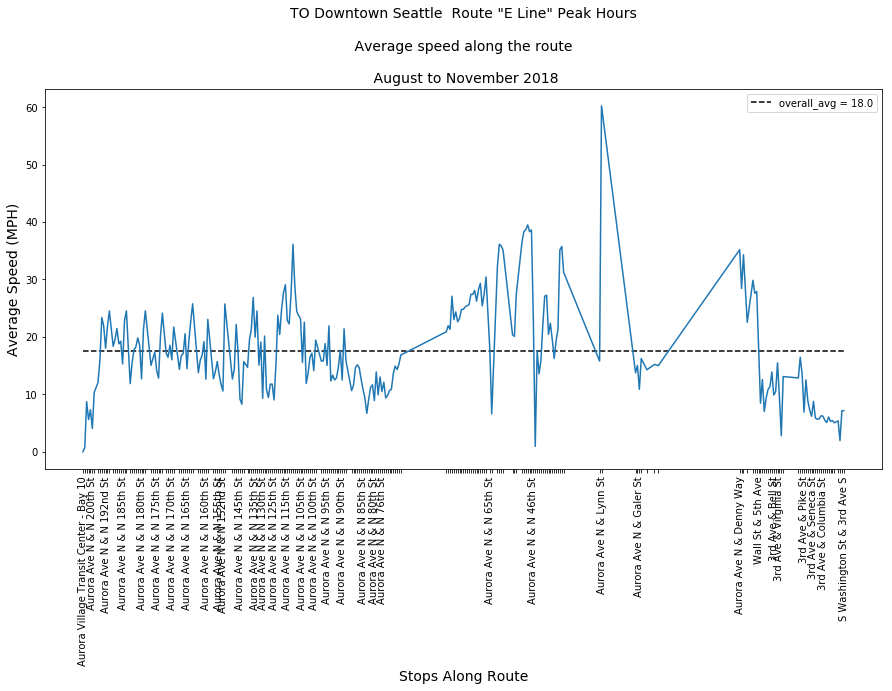

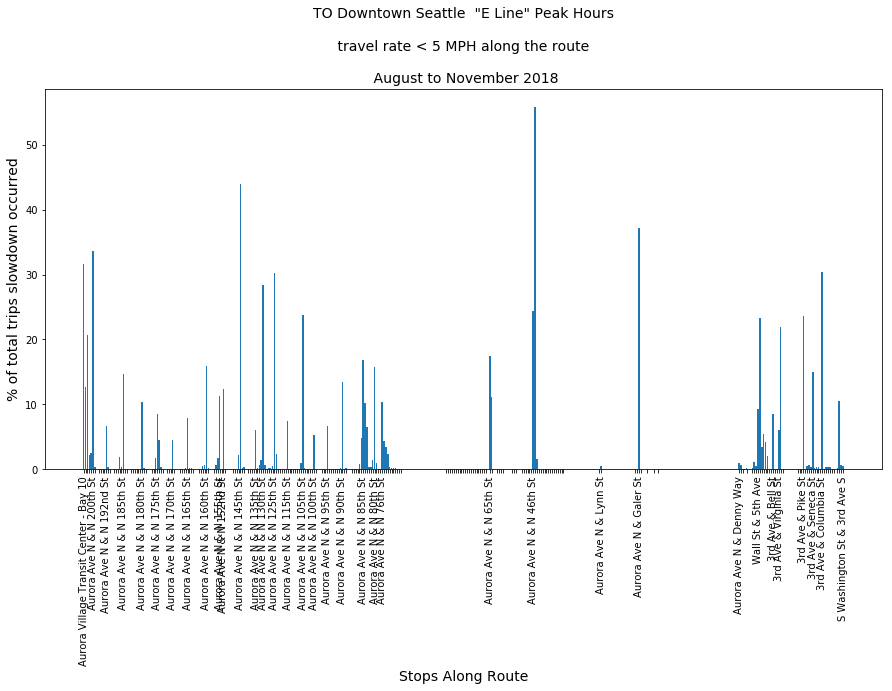

In [10]:
route_of_interest_list = ['41','7', '40','C Line','5', '15','70', 'E Line']
#'D Line'
directions = [0,1]
for route in route_of_interest_list:
    route_of_interest = route
    for direction in directions:
        direction_of_interest = direction
        route_id = route_name_to_id_dict[route_of_interest]
        shape_id, trip_headsign = get_most_used_shape_id_per_direction(full_trip_stop_schedule, 
                                                                       route_id, 
                                                                       direction_of_interest)
        #get file from S3
        base_key = "route_shape_files/"
        csv_name = 'transformed/route_{}_{}_shape_{}_node_trips_w_nearest_2018-08-15_2018-12-11.csv'.format(
                                                        route_of_interest,
                                                        "".join(trip_headsign.replace("/","-").split(" ")) ,
                                                        shape_id)

        file_key = base_key+csv_name
        s3 = boto3.client("s3")
        bucket_name = "malnor.seattle.bustime"
        s3_object = s3.get_object(Bucket=bucket_name, Key=file_key)
        unpacked_positions_full = pd.read_csv(io.BytesIO(s3_object['Body'].read()))
        unpacked_positions_full['distance_btw_veh_and_shape'] = unpacked_positions_full\
                                                                .apply(lambda x: calc_distance(x['vehicle_lat'],
                                                                x['vehicle_long'], 
                                                                x['shape_pt_lat'],
                                                               x['shape_pt_lon']), axis=1)
            
        unpacked_positions_full_preclean = unpacked_positions_full\
            [(unpacked_positions_full['distance_btw_veh_and_shape']<=100)&
            (unpacked_positions_full['shape_dist_diff']>=0)]
        
        #convert time_pct to datetime
        unpacked_positions_full_preclean['time_pct'] = unpacked_positions_full_preclean['time_pct']\
                                                    .apply(pd.to_datetime).copy()
            
        unpacked_positions_full_preclean_newtime = unpacked_positions_full_preclean\
                        .groupby('month_day_trip_veh')\
                        .apply(get_time_diff)
                
        unpacked_positions_full_preclean_newtime['new_total_seconds'] = unpacked_positions_full_preclean_newtime.apply(lambda x: x['new_time_delta'].total_seconds() 
                                                         if x['new_time_delta'] == x['new_time_delta'] 
                                                         else 0, axis=1)
        
        unpacked_positions_full_preclean_newtime['new_veh_mph'] = unpacked_positions_full_preclean_newtime\
                        .apply(lambda x: (x['shape_dist_diff']/5280)
                               /(x['new_total_seconds']/(60*60)) if x['new_total_seconds'] != 0 else 0, axis=1)
            
        
        
        unpacked_positions_clean = unpacked_positions_full_preclean_newtime\
            [(unpacked_positions_full_preclean_newtime['new_veh_mph']>=0)&
            (unpacked_positions_full_preclean_newtime['new_veh_mph']<80)].copy()
        #Metro “Peak” hours: 6 – 9 a.m. and 3 – 7 p.m
        hours_of_interest = [6,7,8,9,15, 16, 17, 18, 19]
        #dow - Monday = 0
        dow_of_interest = [0,1,2,3,4]
        unpacked_positions_clean_hours = unpacked_positions_clean\
                                                [(unpacked_positions_clean['hour'].isin(hours_of_interest))&
                                                (unpacked_positions_clean['dow'].isin(dow_of_interest))]
            
        total_num_trips = len(unpacked_positions_clean_hours['month_day_trip_veh'].unique())
        ten_percent_trips = 10 #total_num_trips*.1
        shape_pt_obs_count = unpacked_positions_clean_hours.pivot_table(values='new_veh_mph', 
                                              index='month_day_trip_veh', 
                                              columns='shape_pt_sequence',
                                                aggfunc='count')\
                                                .sum(axis=0)
        shape_pt_obs_df = pd.DataFrame.from_dict(dict(zip(shape_pt_obs_count.index,
                                                          shape_pt_obs_count.values<ten_percent_trips)), orient='index')

        shape_pt_to_keep = shape_pt_obs_df[shape_pt_obs_df[0]==False].index.tolist()
            
        positions_final_clean = unpacked_positions_clean_hours[unpacked_positions_clean_hours['shape_pt_sequence'].isin(shape_pt_to_keep)]
        
        stop_name_to_sequence_dict = dict(zip(positions_final_clean.shape_pt_sequence.tolist(),
                        ["" if str(x) == "nan" else x for x in positions_final_clean.stop_name.tolist()]))
        
        pivot_avg = positions_final_clean.pivot_table(values='new_veh_mph', 
                                      index='month_day_trip_veh', 
                                      columns='shape_pt_sequence')\
                                        .mean(axis=0)
        x = pivot_avg.index
        overall_avg = pivot_avg.mean()
        x_labels = [stop_name_to_sequence_dict[x_seq] if x_seq in stop_name_to_sequence_dict.keys() else "" for x_seq in x]
        fig, ax = plt.subplots(figsize=(15,7))
        y_avg = pivot_avg.values

        #ax.set_xticklabels(x_labels)
        plt.xticks(x, x_labels, rotation='vertical')
        ax.plot(x, y_avg)
        ax.hlines(overall_avg, xmin=min(x), xmax=max(x), label='overall_avg = {}'.format(round(overall_avg),1), linestyles='dashed')
        ax.set_ylabel("Average Speed (MPH)", fontsize=14)
        ax.set_xlabel("Stops Along Route", fontsize=14)
        title_str = ("""TO {} Route \"{}\" Peak Hours
                        \n Average speed along the route 
                        \n August to November 2018""".format(trip_headsign,
                                                            route_of_interest, hours_of_interest))
        ax.legend()
        _ = ax.set_title(title_str, fontsize=14)
        plt.savefig("".join(title_str.replace('\n','').replace("\"","_").replace("<","_less_").split(" "))+".png", bbox_inches="tight")

        mph_rate_flag = 5 #can change
        unpacked_positions_clean_hours_flag = positions_final_clean.copy()
        unpacked_positions_clean_hours_flag['trouble_flag'] = unpacked_positions_clean_hours_flag\
                                                                        .apply(lambda x: True if x['new_veh_mph'] 
                                                                           < mph_rate_flag else False, axis=1)
            
        stop_name_to_sequence_dict = dict(zip(unpacked_positions_clean_hours_flag.shape_pt_sequence.tolist(),
                        ["" if str(x) == "nan" else x for x in unpacked_positions_clean_hours_flag.stop_name.tolist()]))
        
        total_trips = len(unpacked_positions_clean_hours_flag.month_day_trip_veh.unique())
        pivot_sums = unpacked_positions_clean_hours_flag.pivot_table(values='trouble_flag', 
                                              index='month_day_trip_veh', 
                                              columns='shape_pt_sequence')\
                                                .sum(axis=0)*100/total_trips
        x_pos = pivot_sums.index
        x_labels = [stop_name_to_sequence_dict[x] if x in stop_name_to_sequence_dict.keys() else "" for x in x_pos]
        fig, ax = plt.subplots(figsize=(15,7))
        bar_h = pivot_sums.values
        #ax.set_xticklabels(x_labels)
        plt.xticks(x_pos, x_labels, rotation='vertical')
        ax.bar(x_pos, bar_h)
        ax.set_ylabel("% of total trips slowdown occurred", fontsize=14)
        ax.set_xlabel("Stops Along Route", fontsize=14)
        title_str = ("""TO {} \"{}\" Peak Hours
                        \n travel rate < 5 MPH along the route 
                        \n August to November 2018""".format(trip_headsign,
                                                            route_of_interest, hours_of_interest))
        _ = ax.set_title(title_str, fontsize=14)
        plt.savefig("".join(title_str.replace('\n','').replace("\"","_").replace("<","_less_").split(" "))+".png", bbox_inches="tight")

# generate the file_name and key to pull the transformed data down from AWS S3

In [17]:
base_key = "route_shape_files/"
csv_name = 'transformed/route_{}_{}_shape_{}_node_trips_w_nearest_2018-08-15_2018-12-11.csv'.format(
                                                route_of_interest,
                                                "".join(trip_headsign.replace("/","-").split(" ")) ,
                                                shape_id)

file_key = base_key+csv_name
file_key

'route_shape_files/transformed/route_15_BlueRidge_shape_11015003_node_trips_w_nearest_2018-08-15_2018-12-11.csv'

# Import file from S3

In [18]:
s3 = boto3.client("s3")
bucket_name = "malnor.seattle.bustime"
s3_object = s3.get_object(Bucket=bucket_name, Key=file_key)
unpacked_positions_full = pd.read_csv(io.BytesIO(s3_object['Body'].read()))

# calculate the distance between the vehicle observations and the `nearest` shape_pt - there are outlier cases where the vehicle locations is very far from the route and should be removed

In [8]:
unpacked_positions_full['distance_btw_veh_and_shape'] = unpacked_positions_full\
                                                                .apply(lambda x: calc_distance(x['vehicle_lat'],
                                                                x['vehicle_long'], 
                                                                x['shape_pt_lat'],
                                                               x['shape_pt_lon']), axis=1)

# remove observations where distance between vehicle and shape pt is >100 meters. remove "backwards" trips and remove outlier speeds

In [9]:
unpacked_positions_clean = unpacked_positions_full\
            [(unpacked_positions_full['distance_btw_veh_and_shape']<=100)&
            (unpacked_positions_full['shape_dist_diff']>=0)&
            (unpacked_positions_full['travel_rate_mph']>=0)&
            (unpacked_positions_full['travel_rate_mph']<80)].copy()

# select peak hours and day of week of interest

In [10]:
#Metro “Peak” hours: 6 – 9 a.m. and 3 – 7 p.m
hours_of_interest = [6,7,8,9,15, 16, 17, 18, 19]
#dow - Monday = 0
dow_of_interest = [0,1,2,3,4]
unpacked_positions_clean_hours = unpacked_positions_clean\
                                        [(unpacked_positions_clean['hour'].isin(hours_of_interest))&
                                        (unpacked_positions_clean['dow'].isin(dow_of_interest))]

# make a stop_name dictionary - for x_labels on the graph below

In [11]:
stop_name_to_sequence_dict = dict(zip(unpacked_positions_clean_hours.shape_pt_sequence.tolist(),
                        ["" if str(x) == "nan" else x for x in unpacked_positions_clean_hours.stop_name.tolist()]))

# plot average speed across the route

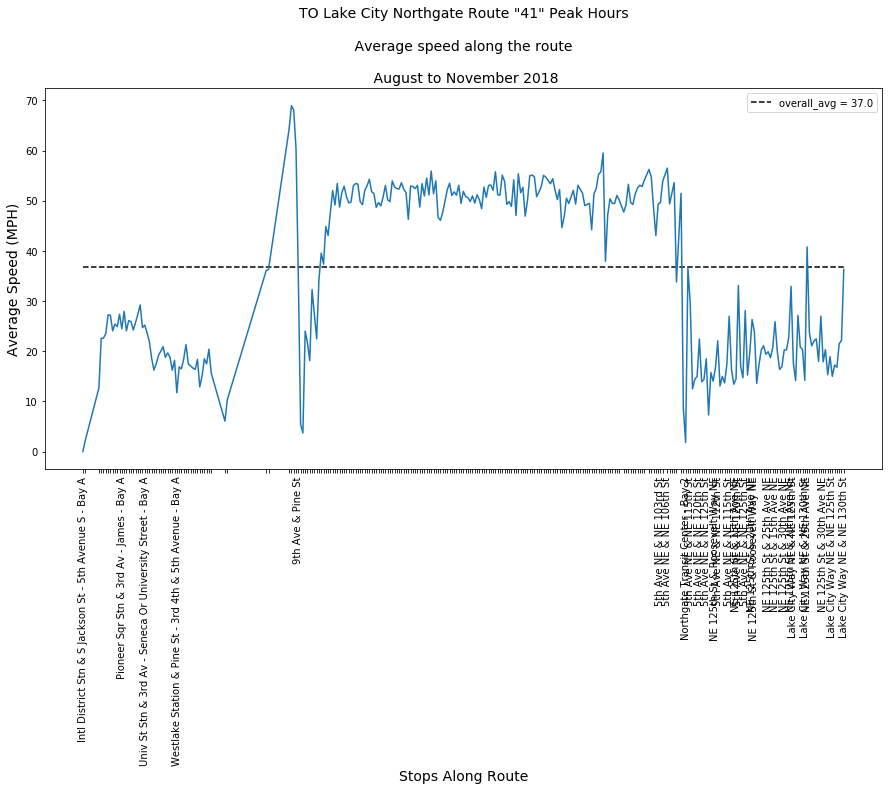

In [12]:
pivot_avg = unpacked_positions_clean_hours.pivot_table(values='travel_rate_mph', 
                                      index='month_day_trip_veh', 
                                      columns='shape_pt_sequence')\
                                        .mean(axis=0)
x = pivot_avg.index
overall_avg = pivot_avg.mean()
x_labels = [stop_name_to_sequence_dict[x_seq] if x_seq in stop_name_to_sequence_dict.keys() else "" for x_seq in x]
fig, ax = plt.subplots(figsize=(15,7))
y_avg = pivot_avg.values

#ax.set_xticklabels(x_labels)
plt.xticks(x, x_labels, rotation='vertical')
ax.plot(x, y_avg)
ax.hlines(overall_avg, xmin=min(x), xmax=max(x), label='overall_avg = {}'.format(round(overall_avg),1), linestyles='dashed')
ax.set_ylabel("Average Speed (MPH)", fontsize=14)
ax.set_xlabel("Stops Along Route", fontsize=14)
title_str = ("""TO {} Route \"{}\" Peak Hours
                \n Average speed along the route 
                \n August to November 2018""".format(trip_headsign,
                                                    route_of_interest, hours_of_interest))
ax.legend()
_ = ax.set_title(title_str, fontsize=14)
plt.savefig("".join(title_str.replace('\n','').replace("\"","_").replace("<","_less_").split(" "))+".png", bbox_inches="tight")

# flag all trip segments with travel_rate < threshold 

In [13]:
mph_rate_flag = 10 #can change
unpacked_positions_clean_hours_flag = unpacked_positions_clean_hours.copy()
unpacked_positions_clean_hours_flag['trouble_flag'] = unpacked_positions_clean_hours_flag\
                                                                .apply(lambda x: True if x['travel_rate_mph'] 
                                                                   < mph_rate_flag else False, axis=1)

# plot slowdown areas with only raw observations

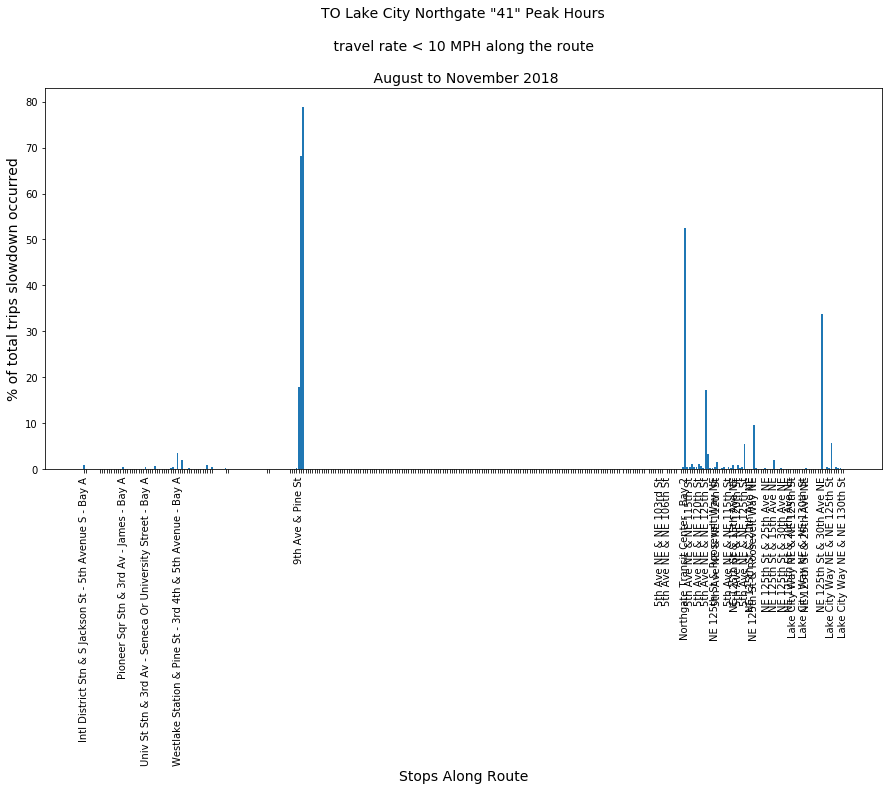

In [14]:
total_trips = len(unpacked_positions_clean_hours_flag.month_day_trip_veh.unique())
pivot_sums = unpacked_positions_clean_hours_flag.pivot_table(values='trouble_flag', 
                                      index='month_day_trip_veh', 
                                      columns='shape_pt_sequence')\
                                        .sum(axis=0)*100/total_trips
x_pos = pivot_sums.index
x_labels = [stop_name_to_sequence_dict[x] if x in stop_name_to_sequence_dict.keys() else "" for x in x_pos]
fig, ax = plt.subplots(figsize=(15,7))
bar_h = pivot_sums.values
#ax.set_xticklabels(x_labels)
plt.xticks(x_pos, x_labels, rotation='vertical')
ax.bar(x_pos, bar_h)
ax.set_ylabel("% of total trips slowdown occurred", fontsize=14)
ax.set_xlabel("Stops Along Route", fontsize=14)
title_str = ("""TO {} \"{}\" Peak Hours
                \n travel rate < 10 MPH along the route 
                \n August to November 2018""".format(trip_headsign,
                                                    route_of_interest, hours_of_interest))
_ = ax.set_title(title_str, fontsize=14)
plt.savefig("".join(title_str.replace('\n','').replace("\"","_").replace("<","_less_").split(" "))+".png", bbox_inches="tight")